# Previsão de renda

## Etapa 1 CRISP - DM: Entendimento do negócio

### Contexto do Projeto
Este projeto visa analisar dados de clientes para prever a renda com base em características demográficas e socioeconômicas.

A previsão precisa de renda pode ser útil para empresas que desejam personalizar suas ofertas, otimizar campanhas de marketing e identificar clientes de alto valor.

A análise e modelagem dos dados ajudarão a entender melhor os fatores que influenciam a renda dos clientes.

### Objetivos de Negócio
1. Melhorar a precisão das previsões de renda dos clientes.
2. Identificar segmentos de clientes com alto potencial de receita.
3. Otimizar campanhas de marketing com base nas previsões de renda.
4. Personalizar ofertas e produtos de acordo com o perfil de renda dos clientes.

### Objetivos de Data Mining
1. Desenvolver um modelo preditivo para estimar a renda dos clientes.
2. Analisar a importância das variáveis no modelo preditivo.
3. Validar o modelo utilizando técnicas de avaliação de desempenho.
4. Gerar insights sobre os fatores que mais influenciam a renda dos clientes.

### Critérios de Sucesso
1. Acurácia do modelo preditivo acima de 85%.
2. Identificação de pelo menos três segmentos de clientes com alto potencial de receita.
3. Implementação bem-sucedida do modelo em um aplicativo Streamlit para uso pela equipe de marketing.
4. Capacidade de gerar relatórios com insights acionáveis para a equipe de marketing.

## Etapa 2 Crisp-DM: Entendimento dos dados

### Dicionário de dados



| Variável                | Descrição                                           | Tipo         |
| ----------------------- |:---------------------------------------------------:| ------------:|
| data_ref                |  data de referência dos dados                       | Date|
| id_cliente              |  identificação única do cliente                     | Integer|
| sexo                    |  gênero do cliente (ex: M, F)                       | Categorical|
| posse_de_veiculo        |  cliente possui veículo (1 = Sim, 0 = Não)          | Boolean|
| posse_de_imovel         |  cliente possui imóvel (1 = Sim, 0 = Não)           | Boolean|
| qtd_filhos              |  quantidade de filhos do cliente                    | Integer|
| tipo_renda              |  tipo de renda (ex: Assalariado, Autônomo)          | Categorical|
| educacao                |  nível de educação do cliente                       | Categorical|
| estado_civil            |  estado civil do cliente (ex: Solteiro, Casado)     | Categorical|
| tipo_residencia         |  tipo de residência (ex: Própria, Alugada)          | Categorical|
| idade                   |  idade do cliente                                   | Integer|
| tempo_emprego           |  tempo de emprego atual em anos                     | Float|
| qt_pessoas_residencia   |  quantidade de pessoas na residência do cliente     | Integer|
| renda                   |  Renda do cliente                                   | Float|





### Carregando os pacotes

In [6]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import xgboost as xgb

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor
from ydata_profiling import ProfileReport

warnings.filterwarnings('ignore', category=FutureWarning)


### Carregando os dados

In [7]:
file_path = 'E:\Python\Projetos\previsao_renda\previsao_de_renda.csv'
dados = pd.read_csv(file_path, index_col=0)
dados.head(5)

,data_ref,id_cliente,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
0,2015-01-01,15056,F,False,True,0,Empresário,Secundário,Solteiro,Casa,26,6.602740,1.0,8060.34
1,2015-01-01,9968,M,True,True,0,Assalariado,Superior completo,Casado,Casa,28,7.183562,2.0,1852.15
2,2015-01-01,4312,F,True,True,0,Empresário,Superior completo,Casado,Casa,35,0.838356,2.0,2253.89
3,2015-01-01,10639,F,False,True,1,Servidor público,Superior completo,Casado,Casa,30,4.846575,3.0,6600.77
4,2015-01-01,7064,M,True,False,0,Assalariado,Secundário,Solteiro,Governamental,33,4.293151,1.0,6475.97


### Análise Exploratória dos Dados

In [8]:
dados.info()
dados.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Index: 15000 entries, 0 to 14999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   data_ref               15000 non-null  object 
 1   id_cliente             15000 non-null  int64  
 2   sexo                   15000 non-null  object 
 3   posse_de_veiculo       15000 non-null  bool   
 4   posse_de_imovel        15000 non-null  bool   
 5   qtd_filhos             15000 non-null  int64  
 6   tipo_renda             15000 non-null  object 
 7   educacao               15000 non-null  object 
 8   estado_civil           15000 non-null  object 
 9   tipo_residencia        15000 non-null  object 
 10  idade                  15000 non-null  int64  
 11  tempo_emprego          12427 non-null  float64
 12  qt_pessoas_residencia  15000 non-null  float64
 13  renda                  15000 non-null  float64
dtypes: bool(2), float64(3), int64(3), object(6)
memory usage: 1

data_ref                    0
id_cliente                  0
sexo                        0
posse_de_veiculo            0
posse_de_imovel             0
qtd_filhos                  0
tipo_renda                  0
educacao                    0
estado_civil                0
tipo_residencia             0
idade                       0
tempo_emprego            2573
qt_pessoas_residencia       0
renda                       0
dtype: int64

#### Tratamento de valores ausentes (tempo_emprego)
Realizado o preenchimento com a Mediana dos valores

In [9]:
dados['tempo_emprego'].fillna(dados['tempo_emprego'].median(), inplace=True)
dados.isnull().sum()

data_ref                 0
id_cliente               0
sexo                     0
posse_de_veiculo         0
posse_de_imovel          0
qtd_filhos               0
tipo_renda               0
educacao                 0
estado_civil             0
tipo_residencia          0
idade                    0
tempo_emprego            0
qt_pessoas_residencia    0
renda                    0
dtype: int64

In [10]:
dados.describe()

,id_cliente,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,8304.871400,0.432333,43.882333,7.429495,2.206400,5697.287057
std,4797.780446,0.746631,11.273155,6.142371,0.909792,8266.816289
min,1.000000,0.000000,22.000000,0.117808,1.000000,118.710000
25%,4181.000000,0.000000,34.000000,3.602740,2.000000,2026.110000
50%,8297.000000,0.000000,43.000000,6.013699,2.000000,3499.720000
75%,12403.000000,1.000000,53.000000,8.961644,3.000000,6392.167500
max,16649.000000,14.000000,68.000000,42.906849,15.000000,245141.670000


### Exploração Visual dos Dados

#### Visualização das Variáveis Categóricas

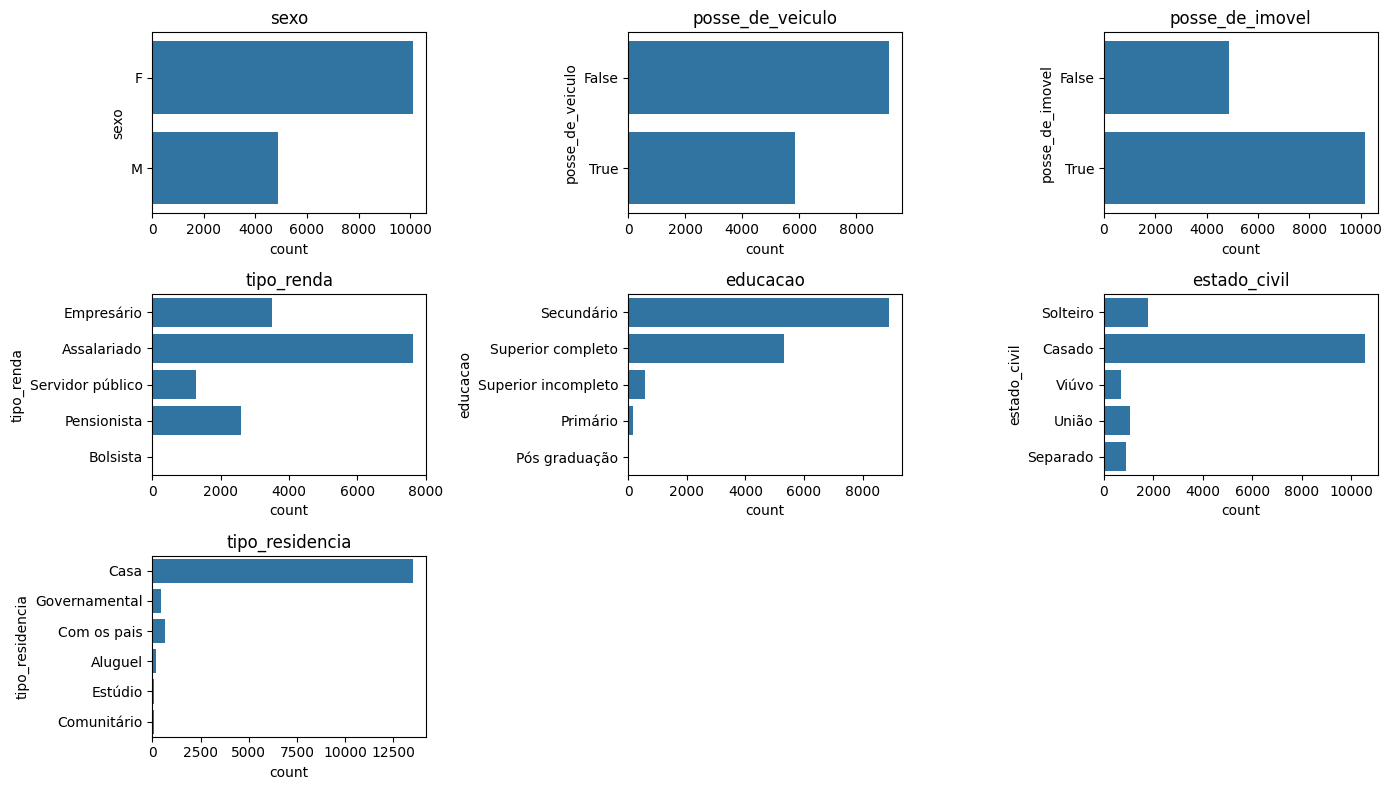

In [12]:
plt.figure(figsize=(14, 8))

categorical_cols = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia']
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(3, 3, i)
    sns.countplot(y=dados[col])
    plt.title(col)

plt.tight_layout()
plt.show()

#### Análise de Correlação das Variáveis Numéricas

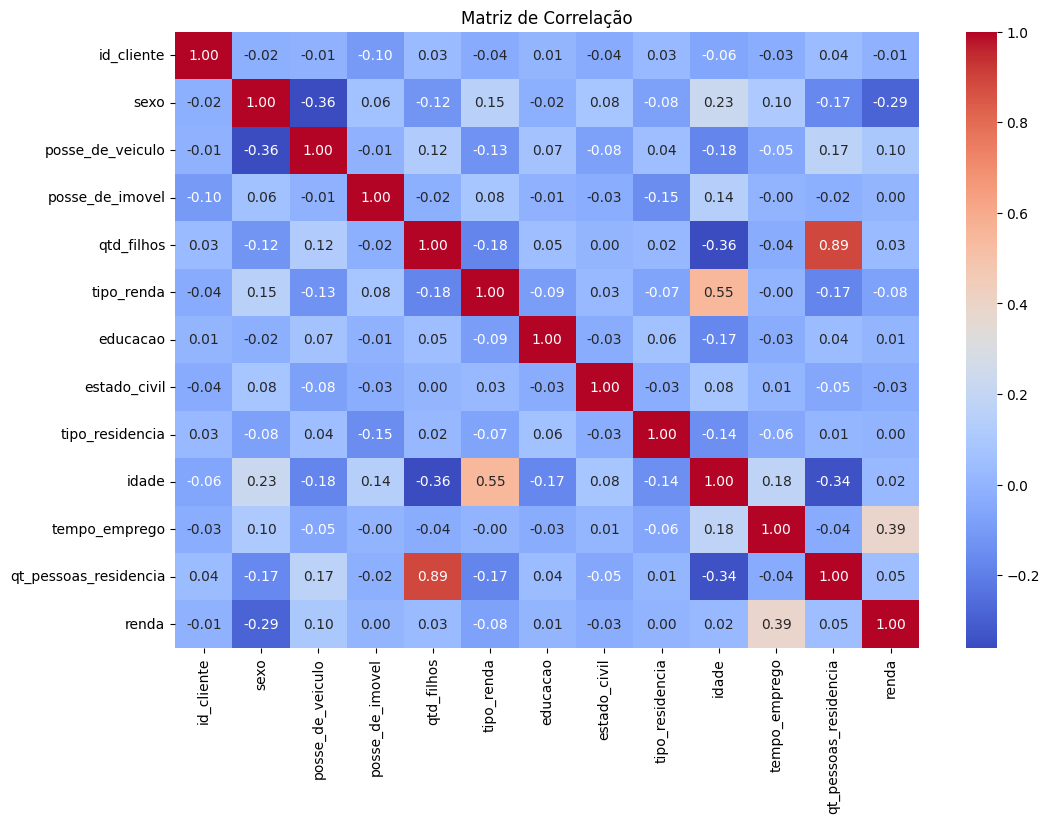

In [13]:
dados['sexo'] = dados['sexo'].map({'M': 0, 'F': 1})
dados['posse_de_veiculo'] = dados['posse_de_veiculo'].astype(int)
dados['posse_de_imovel'] = dados['posse_de_imovel'].astype(int)
dados['tipo_renda'] = dados['tipo_renda'].factorize()[0]
dados['educacao'] = dados['educacao'].factorize()[0]
dados['estado_civil'] = dados['estado_civil'].factorize()[0]
dados['tipo_residencia'] = dados['tipo_residencia'].factorize()[0]

dados['data_ref'] = pd.to_datetime(dados['data_ref'])
dados_num = dados.drop(columns=['data_ref'])


correlation_matrix = dados_num.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlação')
plt.show()

#### Entendimento dos dados - Univariada

In [14]:
prof = ProfileReport(dados, explorative=True, minimal=True)
prof.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [15]:
prof.to_file("relatorio_exploratorio.html")

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### Distribuição das Variáveis Numéricas


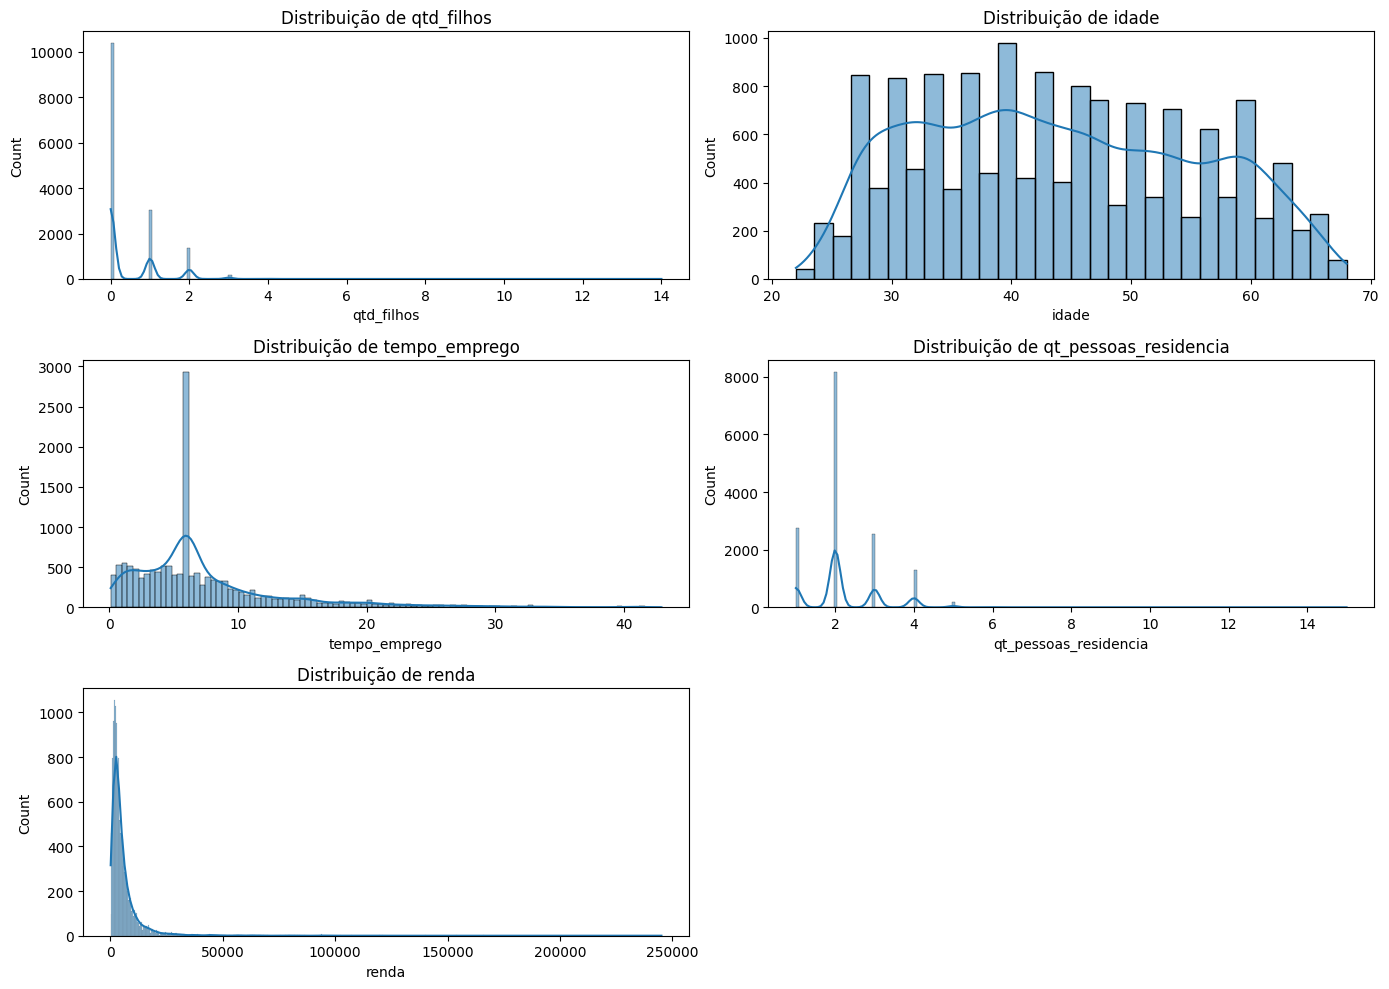

In [16]:
num_cols = ['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']

plt.figure(figsize=(14, 10))
for i, col in enumerate(num_cols, 1):
    plt.subplot(3, 2, i)
    sns.histplot(dados[col], kde=True)
    plt.title(f'Distribuição de {col}')

plt.tight_layout()
plt.show()

### Distribuição das Variáveis Categóricas

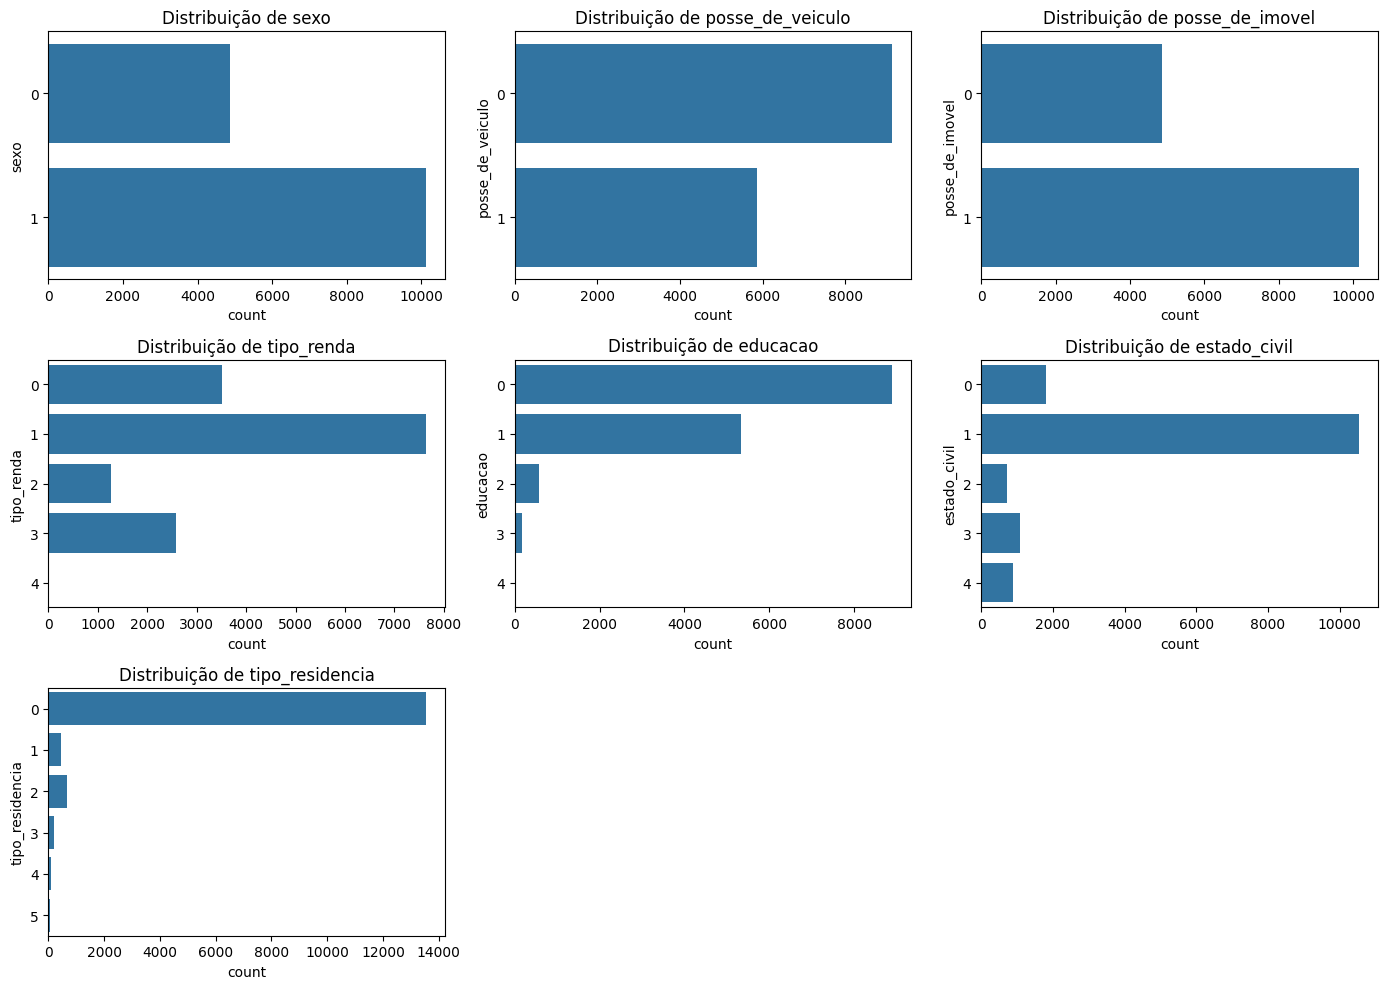

In [17]:
plt.figure(figsize=(14, 10))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(3, 3, i)
    sns.countplot(y=dados[col])
    plt.title(f'Distribuição de {col}')

plt.tight_layout()
plt.show()

### Entendimento dos dados - Bivariadas




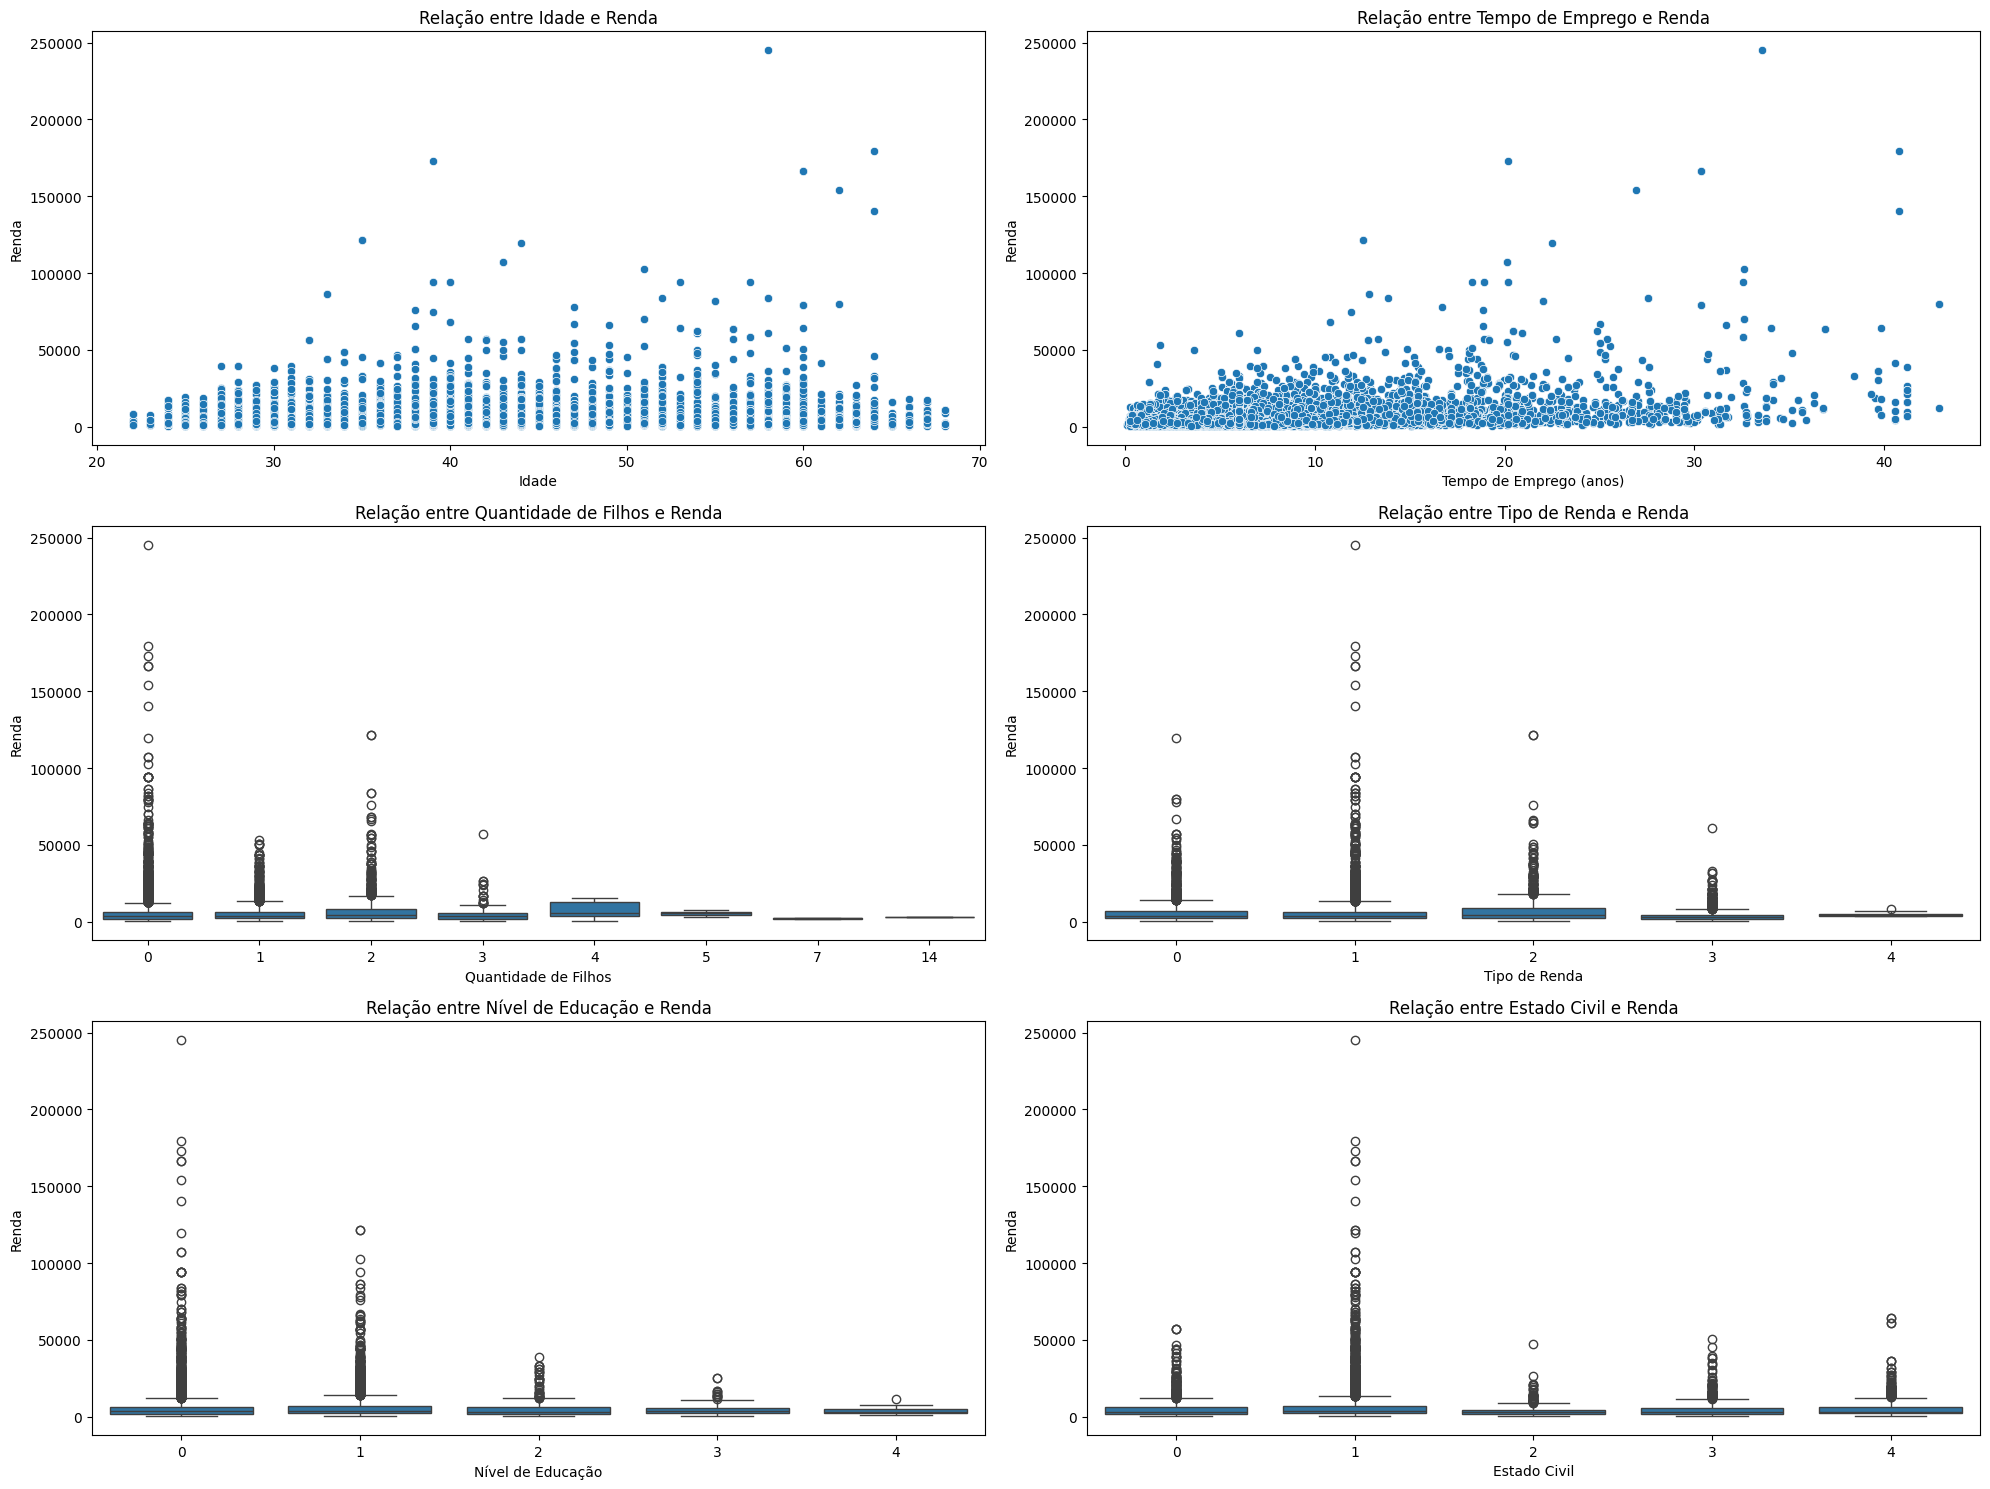

In [18]:
fig, axes = plt.subplots(3, 2, figsize=(20, 15))

# Idade e Renda
sns.scatterplot(data=dados, x='idade', y='renda', ax=axes[0, 0])
axes[0, 0].set_title('Relação entre Idade e Renda')
axes[0, 0].set_xlabel('Idade')
axes[0, 0].set_ylabel('Renda')

# Tempo de Emprego e Renda
sns.scatterplot(data=dados, x='tempo_emprego', y='renda', ax=axes[0, 1])
axes[0, 1].set_title('Relação entre Tempo de Emprego e Renda')
axes[0, 1].set_xlabel('Tempo de Emprego (anos)')
axes[0, 1].set_ylabel('Renda')

# Quantidade de Filhos e Renda
sns.boxplot(data=dados, x='qtd_filhos', y='renda', ax=axes[1, 0])
axes[1, 0].set_title('Relação entre Quantidade de Filhos e Renda')
axes[1, 0].set_xlabel('Quantidade de Filhos')
axes[1, 0].set_ylabel('Renda')

# Tipo de Renda e Renda
sns.boxplot(data=dados, x='tipo_renda', y='renda', ax=axes[1, 1])
axes[1, 1].set_title('Relação entre Tipo de Renda e Renda')
axes[1, 1].set_xlabel('Tipo de Renda')
axes[1, 1].set_ylabel('Renda')

# Nível de Educação e Renda
sns.boxplot(data=dados, x='educacao', y='renda', ax=axes[2, 0])
axes[2, 0].set_title('Relação entre Nível de Educação e Renda')
axes[2, 0].set_xlabel('Nível de Educação')
axes[2, 0].set_ylabel('Renda')

# Estado Civil e Renda
sns.boxplot(data=dados, x='estado_civil', y='renda', ax=axes[2, 1])
axes[2, 1].set_title('Relação entre Estado Civil e Renda')
axes[2, 1].set_xlabel('Estado Civil')
axes[2, 1].set_ylabel('Renda')

plt.tight_layout()
plt.show()

## Etapa 3 Crisp-DM: Preparação dos dados

### Seleção dos dados


In [19]:
print("Variáveis selecionadas:")
print(dados.columns)

Variáveis selecionadas:
Index(['data_ref', 'id_cliente', 'sexo', 'posse_de_veiculo', 'posse_de_imovel',
       'qtd_filhos', 'tipo_renda', 'educacao', 'estado_civil',
       'tipo_residencia', 'idade', 'tempo_emprego', 'qt_pessoas_residencia',
       'renda'],
      dtype='object')


### Limpeza dos dados

In [20]:
print("Valores ausentes por coluna:")
print(dados.isnull().sum())

dados['tempo_emprego'].fillna(dados['tempo_emprego'].median(), inplace=True)

print("Valores ausentes após tratamento:")
print(dados.isnull().sum())


Valores ausentes por coluna:
data_ref                 0
id_cliente               0
sexo                     0
posse_de_veiculo         0
posse_de_imovel          0
qtd_filhos               0
tipo_renda               0
educacao                 0
estado_civil             0
tipo_residencia          0
idade                    0
tempo_emprego            0
qt_pessoas_residencia    0
renda                    0
dtype: int64
Valores ausentes após tratamento:
data_ref                 0
id_cliente               0
sexo                     0
posse_de_veiculo         0
posse_de_imovel          0
qtd_filhos               0
tipo_renda               0
educacao                 0
estado_civil             0
tipo_residencia          0
idade                    0
tempo_emprego            0
qt_pessoas_residencia    0
renda                    0
dtype: int64


### Formatação dos dados

In [41]:
# Formatação dos dados
dados['idade_ao_quadrado'] = dados['idade'] ** 2

# features e target
X = dados.drop(columns=['renda'])
y = dados['renda']

# split treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# padronizando variáveis numéricas e codificando variáveis categóricas
numeric_features = ['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'idade_ao_quadrado']
categorical_features = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia']

# Criando o ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

# Ajustar e transformar os dados de treinamento e teste
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print(f'X_train shape: {X_train_processed.shape}')
print(f'X_test shape: {X_test_processed.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (10500, 32)
X_test shape: (4500, 32)
y_train shape: (10500,)
y_test shape: (4500,)


## Etapa 4 Crisp-DM: Modelagem

### Regressão Linear

In [43]:
# treinar o modelo de regresao linear
lr_model = LinearRegression()
lr_model.fit(X_train_processed, y_train)

# previews
y_train_pred = lr_model.predict(X_train_processed)
y_test_pred = lr_model.predict(X_test_processed)

# avaliar o modelo
print("Regressão Linear:")
print("RMSE Treino:", mean_squared_error(y_train, y_train_pred, squared=False))
print("RMSE Teste:", mean_squared_error(y_test, y_test_pred, squared=False))
print("MAE Treino:", mean_absolute_error(y_train, y_train_pred))
print("MAE Teste:", mean_absolute_error(y_test, y_test_pred))
print("R² Treino:", r2_score(y_train, y_train_pred))
print("R² Teste:", r2_score(y_test, y_test_pred))


Regressão Linear:
RMSE Treino: 7174.907299791032
RMSE Teste: 6922.0714464836
MAE Treino: 3622.8272485714283
MAE Teste: 3622.732368888889
R² Treino: 0.2581794116965205
R² Teste: 0.27221480169784806


### Random Forest

In [44]:
# treinar o modelo de random forest
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train_processed, y_train)

# previews
y_train_pred = rf_model.predict(X_train_processed)
y_test_pred = rf_model.predict(X_test_processed)

# avaliar o modelo
print("Random Forest:")
print("RMSE Treino:", mean_squared_error(y_train, y_train_pred, squared=False))
print("RMSE Teste:", mean_squared_error(y_test, y_test_pred, squared=False))
print("MAE Treino:", mean_absolute_error(y_train, y_train_pred))
print("MAE Teste:", mean_absolute_error(y_test, y_test_pred))
print("R² Treino:", r2_score(y_train, y_train_pred))
print("R² Teste:", r2_score(y_test, y_test_pred))

Random Forest:
RMSE Treino: 3570.2590583594483
RMSE Teste: 6343.8240479627775
MAE Treino: 1770.4293668211915
MAE Teste: 2951.97811685241
R² Treino: 0.8163183579364169
R² Teste: 0.38872966307799917


### Árvore de Decisão

In [24]:

# treinar o modelo de decision tree
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train_processed, y_train)

# previews
y_train_pred = dt_model.predict(X_train_processed)
y_test_pred = dt_model.predict(X_test_processed)

# avaliar o modelo
print("Árvore de Decisão:")
print("RMSE Treino:", mean_squared_error(y_train, y_train_pred, squared=False))
print("RMSE Teste:", mean_squared_error(y_test, y_test_pred, squared=False))
print("MAE Treino:", mean_absolute_error(y_train, y_train_pred))
print("MAE Teste:", mean_absolute_error(y_test, y_test_pred))
print("R² Treino:", r2_score(y_train, y_train_pred))
print("R² Teste:", r2_score(y_test, y_test_pred))


Árvore de Decisão:
RMSE Treino: 3274.3314608848477
RMSE Teste: 6869.193149787313
MAE Treino: 1418.3059300611053
MAE Teste: 3022.6841297971537
R² Treino: 0.8455060149009463
R² Teste: 0.2832915582722685


### XGBoost

In [45]:
# treinar o modelo de XGBoost
xgb_model = xgb.XGBRegressor(random_state=42)
xgb_model.fit(X_train_processed, y_train)

# previews
y_train_pred = xgb_model.predict(X_train_processed)
y_test_pred = xgb_model.predict(X_test_processed)

# avaliar o modelo
print("XGBoost:")
print("RMSE Treino:", mean_squared_error(y_train, y_train_pred, squared=False))
print("RMSE Teste:", mean_squared_error(y_test, y_test_pred, squared=False))
print("MAE Treino:", mean_absolute_error(y_train, y_train_pred))
print("MAE Teste:", mean_absolute_error(y_test, y_test_pred))
print("R² Treino:", r2_score(y_train, y_train_pred))
print("R² Teste:", r2_score(y_test, y_test_pred))


XGBoost:
RMSE Treino: 3806.0947379440818
RMSE Teste: 6527.218754430756
MAE Treino: 2217.684881170945
MAE Teste: 3075.6161191303167
R² Treino: 0.7912504816454287
R² Teste: 0.352876160076119


## Análise dos Resultados


### Regressão Linear

1. Menor desempenho em comparação aos outros modelos
2. Menores valores de R² indicam que a Regressão Linear não é adequada para capturar a complexidade dos dados.

### Random Forest

1. Melhor R² de teste entre os modelos, mas ainda há uma diferença significativa entre treino e teste, sugerindo overfitting.
2. O RMSE e MAE de teste são relativamente baixos, indicando um bom desempenho geral.

### Árvore de Decisão

1. Alto desempenho nos dados de treino, mas sofre de overfitting, como indicado pelo aumento no RMSE e MAE de teste e pela queda no R² de teste.

### XGBoost

1. Equilíbrio decente entre desempenho de treino e teste.
2. Embora tenha um bom desempenho geral, o Random Forest ainda possui o melhor R² de teste.

## Etapa 5 Crisp-DM: Avaliação dos resultados
Visto que o modelo que mostrou melhor desempenho até agora foi o Random Forest, realizarei o tuning para melhorar a performance e evitar overfitting assim como, tecnicas de validação cruzada.

## Tuning de Hiperparâmetros



In [48]:
# definindo os parâmetros para o grid search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf_model = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=1, verbose=2)
grid_search.fit(X_train_processed, y_train)

# melhor estimador encontrado
best_rf_model = grid_search.best_estimator_

# previsões com o melhor modelo
y_train_pred = best_rf_model.predict(X_train_processed)
y_test_pred = best_rf_model.predict(X_test_processed)

# avaliar o melhor modelo
print("Random Forest com Tuning de Hiperparâmetros:")
print("RMSE Treino:", mean_squared_error(y_train, y_train_pred, squared=False))
print("RMSE Teste:", mean_squared_error(y_test, y_test_pred, squared=False))
print("MAE Treino:", mean_absolute_error(y_train, y_train_pred))
print("MAE Teste:", mean_absolute_error(y_test, y_test_pred))
print("R² Treino:", r2_score(y_train, y_train_pred))
print("R² Teste:", r2_score(y_test, y_test_pred))

Fitting 5 folds for each of 162 candidates, totalling 810 fits
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.5s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.5s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.5s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.5s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.5s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   3.1s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   3.1s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   3.0s
[

e:\Python\Projetos\venv\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Random Forest com Tuning de Hiperparâmetros:
RMSE Treino: 4021.1023460038923
RMSE Teste: 6191.27429712702
MAE Treino: 2022.8786460476933
MAE Teste: 2961.5617884857406
R² Treino: 0.7669996637319105
R² Teste: 0.4177745915803478


### Resultados após Tuning de Hiperparâmetros

#### Desempenho no Treino
1. O modelo apresenta um bom ajuste aos dados de treino, com um R² de 0.766.
2. O MAE no treino é 2028.68, indicando que, em média, as previsões estão cerca de 2028 unidades monetárias afastadas dos valores reais.

#### Desempenho no Treino
1. O R² de 0.417 no conjunto de teste é uma melhoria em relação aos valores obtidos anteriormente, indicando que o modelo está explicando uma maior proporção da variabilidade nos dados de teste.
2. O MAE no teste é 2960.88, o que também é uma melhoria em relação ao desempenho anterior.

O modelo de Random Forest após o tuning de hiperparâmetros tem o melhor desempenho, com o maior valor de R² Teste (0.417) e um MAE Teste relativamente baixo.

## Implementação da Validação Cruzada e Análise de Feature Importance

Validação Cruzada R² Scores: [0.50512556 0.49598546 0.5380633  0.5361093  0.43477604]
Validação Cruzada R² Média: 0.5020119311447033


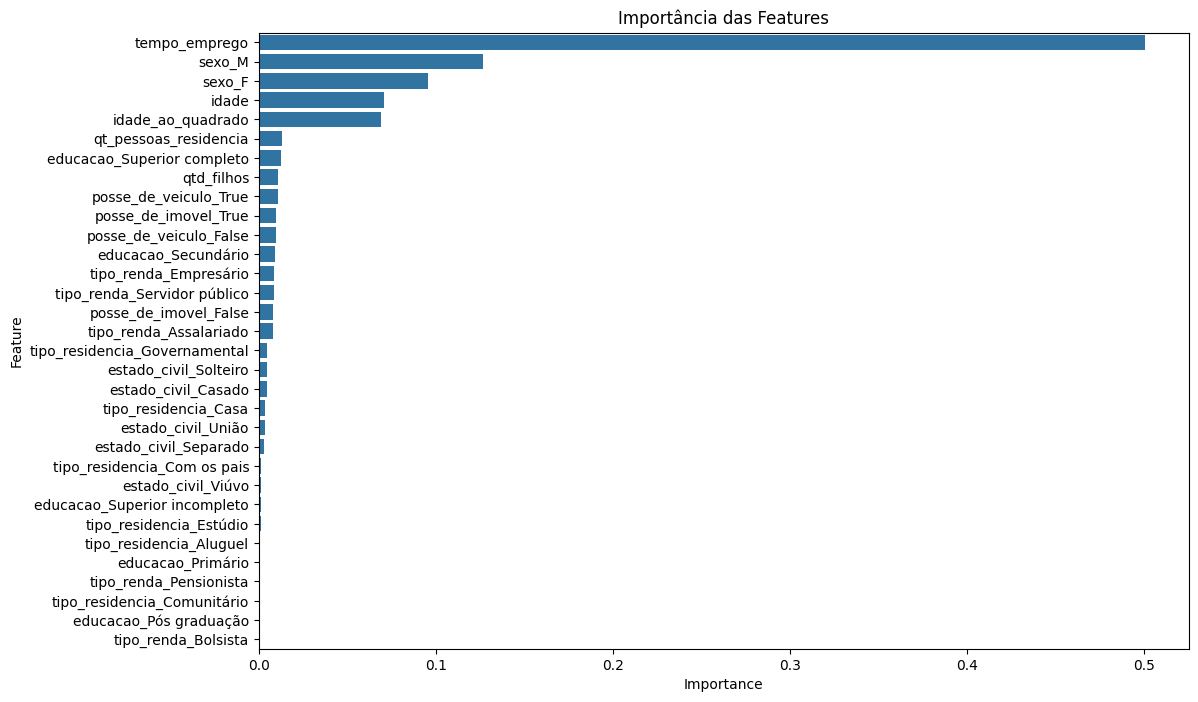

In [49]:
# validação cruzada
cv_scores = cross_val_score(best_rf_model, X_train_processed, y_train, cv=5, scoring='r2')
print("Validação Cruzada R² Scores:", cv_scores)
print("Validação Cruzada R² Média:", cv_scores.mean())

# feature importance
importances = best_rf_model.feature_importances_
feature_names = numeric_features + list(preprocessor.named_transformers_['cat'].get_feature_names_out())
feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Importância das Features')
plt.show()

### Resultados do Cross-Validation e Feature Importance

Tempo de Emprego: A variável mais importante.

Sexo: Diferenciação entre os gêneros tem uma importância significativa.

Idade ao Quadrado: A variável derivada da idade tem uma importância considerável.

Idade: Importância direta da idade.

Educação: Diferentes níveis de educação contribuem de forma significativa.

## Etapa 6 Crisp-DM: Implantação

### Salvar o modelo para Implantação

In [50]:
# salvar o modelo
joblib.dump(best_rf_model, 'best_rf_model.pkl')
print("Modelo salvo como 'best_rf_model.pkl'")

# salvar o preprocessador
joblib.dump(preprocessor, 'preprocessor.pkl')
print("Preprocessador salvo como 'preprocessor.pkl'")

Modelo salvo como 'best_rf_model.pkl'
Preprocessador salvo como 'preprocessor.pkl'


# Executando o aplicativo de Previsão de Renda

### Você pode executar no terminal o comando
Verifique se o preprocessor está salvo corretamente na pasta do projeto

Execute o comando no terminal: streamlit run app.py

In [53]:
!streamlit run app.py

^C
